### Group Details

- Anshul Panda - 7067465
- Allison Kim - 4094439
- Sharanya Sharma - 6252969
- Kaitlin Khong - 4754073

# Introduction

Voter turnout is pivotal for the health of the US democratic system. With the exponential growth of available data, leveraging it to understand the factors behind voter participation dispartieis becomes imperative. This study uses data from the voter files of 2020, which contains every registered voter's geographic, demographic and household information across states, to understand voting patterns within the state of Wyoming. Characterized by its distinctive mix of rural expansiveness and demographic homogeneity, Wyoming presents a unique case against the nation's trends of increasing racial and ethnic diversity. Our analysis aims to uncover the factors that influence electoral engagement.

Upon looking at the 'voter files' file, we saw that there was an abundance of data, both in the number of rows and number of columns. First, we loaded the data using PySpark, a python library meant for big data analytics, and then counted the number of columns and rows.

In [2]:
# Load dataset using PySpark
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("Read Voter File Data") \
.getOrCreate()
df = (
spark.read
.format("parquet")
.option("header", "true")
.option("inferSchema", "true")
.load("gs://winter-2024-voter-file/VM2Uniform/VM2Uniform--WY--2021-01-13")
)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/20 05:28:09 INFO SparkEnv: Registering MapOutputTracker
24/03/20 05:28:09 INFO SparkEnv: Registering BlockManagerMaster
24/03/20 05:28:09 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/03/20 05:28:09 INFO SparkEnv: Registering OutputCommitCoordinator


In [2]:
# Count the number of rows and columns
num_rows = df.count()
columns = df.columns
num_columns = len(columns)

# Print the number of rows and columns
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 290408
Number of columns: 726


We found that each row in the dataset represented an individual, and the different data collected on them about the 2020 election. We expected to be dealing with a vast amount of rows, but having to choose features from 726 columns seemed a little daunting at first. Initially, we knew that we wanted to investigate how socioeconomic factors, such as income, wealth, ethnicity, location, and gender affect voter participation and political party affiliation in Wyoming. Our next step was to narrow our focus and see which columns of the dataset represented these factors. We chose these columns and found out what they meant:

Predictor Variables:
- CommercialData_EstimatedHHIncomeAmount: an individual's estimated household income amount (US$ amount)

- CommercialData_EstHomeValue: an individual's estimated home value (US$ amount)
- County: the county an indvidual voted from
- Ethnic_Description: an individual's ethnic background
- Voters_Gender: an individual's sex (M='male' or F='female')


Response Variables:
- Voters_Active: whether an individual was an 'active' voter (A) or an 'inactive' voter (I)
- Parties_Description: the political party an individual voted for

## Our Research Questions

Since we knew we wanted to predict voter participation and party affiliation, we settled on the following research questions:
1) In the state of Wyoming, how do income, wealth, location, ethnicity, and gender affect voter participation?
2) Do these same factors affect the political party active voters affiliate with?

We planned to preprocess and clean the data, conduct explanatory data analysis on the dataset, and then run models to answer our first research question, then our second research question.

# Data Preprocessing

### Creating a Subset

Before we can conduct our explanatory data analysis on this dataset, we created a subset of the large dataset we read, limiting it to just the columns we need. We then printed out the 'Voters_Active.'

In [3]:
# Creating dataset subset for active voters
desired_column_names = ["CommercialData_EstimatedHHIncomeAmount", 
                        "CommercialData_EstHomeValue",
                        "County",
                        "Ethnic_Description",
                        "Voters_Gender",
                        "Voters_Active",
                        "Parties_Description"
                       ]

subset_df = df.select(desired_column_names)
voter_data = subset_df

### Calculating Percentage of Missing Values

Afterwards, we wanted to see what the percentage of missing values were in each column, so that we would knew how to deal with missing values. 

In [5]:
# Calculate the percentage of missing values for each column
from pyspark.sql.functions import col
total_rows = voter_data.count()

missing_percentages = []
for col_name in voter_data.columns:
    # Count the number of null values in the column
    missing_count = voter_data.filter(col(col_name).isNull()).count()
    # Calculate the percentage of missing values
    missing_percentage = (missing_count / total_rows) * 100
    missing_percentages.append((col_name, missing_percentage))

for col_name, percentage in missing_percentages:
    print(f"Percentage of missing values in column '{col_name}': {percentage:.2f}%")

Percentage of missing values in column 'CommercialData_EstimatedHHIncomeAmount': 6.41%
Percentage of missing values in column 'CommercialData_EstHomeValue': 8.84%
Percentage of missing values in column 'County': 0.00%
Percentage of missing values in column 'Ethnic_Description': 10.05%
Percentage of missing values in column 'Voters_Gender': 1.16%
Percentage of missing values in column 'Voters_Active': 0.00%
Percentage of missing values in column 'Parties_Description': 0.00%


### Data Cleaning

We started our cleaning by converting our quantitative columns, 'CommercialData_EstimatedHHIncomeAmount' and 'CommercialData_EstHomeValue,' to integers. They were originally represented as strings on the dataset. Then for conveniance purposes we renamed these columns to 'Home Value' and 'HH_Income_Amount.'

All of the columns had missing value percentages of under 10% except for 'Ethnic_Description.' For our quantitative columns, 'CommercialData_EstimatedHHIncomeAmount' and 'CommercialData_EstHomeValue,' we decided to imputate based on the median of each of the column. Since only under 10% of the data was missing, we figured that this technique is justifiable. 

For 'Voters_Gender,' a categorical variable, there were only about 1% of the values missing, so we decided to remove those rows from the dataset. For 'Ethnic_Description', there were about 10% values missing, so we decided to add a possible value to the column called 'Unkown,' representing any type of 'null' or 'None' value.   

This entire process is demonstrated here:

In [7]:
# Data cleaning with PySpark

from pyspark.sql.functions import expr
from pyspark.sql.functions import when

# remove dollar sign
voter_data = voter_data.withColumn("CommercialData_EstHomeValue", expr("substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))"))
voter_data = voter_data.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))"))

# convert non-numeric strings to NaN
voter_data = voter_data.withColumn("CommercialData_EstHomeValue", col("CommercialData_EstHomeValue").cast("double"))
voter_data = voter_data.withColumn("CommercialData_EstimatedHHIncomeAmount", col("CommercialData_EstimatedHHIncomeAmount").cast("double"))

# rename columns
voter_data = voter_data.withColumnRenamed("CommercialData_EstHomeValue", "Home_Value") \
       .withColumnRenamed("CommercialData_EstimatedHHIncomeAmount", "HH_Income_Amount") \

# calculate the median for the numeric columns
hh_income_median = voter_data.approxQuantile('HH_Income_Amount', [0.5], 0.001)[0]
home_value_median = voter_data.approxQuantile('Home_Value', [0.5], 0.001)[0]

# impute missing values with the median
voter_data = voter_data.fillna(hh_income_median, subset=['HH_Income_Amount'])
voter_data = voter_data.fillna(home_value_median, subset=['Home_Value'])
voter_data = voter_data.filter((col('Voters_Gender') == 'M') | (col('Voters_Gender') == 'F'))

# replace null and "None" values in the "Ethnic_Description" column with "Unknown"
voter_data = voter_data.withColumn('Ethnic_Description', 
                                   when((col('Ethnic_Description').isNull()) | (col('Ethnic_Description') == 'None'), 'Unknown')
                                   .otherwise(col('Ethnic_Description')))
voter_data_pandas = voter_data.toPandas()
voter_data_pandas_2 = voter_data_pandas.copy()

voter_data.show(10)

+----------------+----------+------+------------------+-------------+-------------+-------------------+
|HH_Income_Amount|Home_Value|County|Ethnic_Description|Voters_Gender|Voters_Active|Parties_Description|
+----------------+----------+------+------------------+-------------+-------------+-------------------+
|         47000.0|  253332.0|ALBANY|             Irish|            M|            I|        Libertarian|
|         46718.0|  177015.0|ALBANY|     English/Welsh|            M|            I|         Republican|
|          6000.0|  287499.0|ALBANY|             Irish|            F|            I|         Democratic|
|         20832.0|  287499.0|ALBANY|     English/Welsh|            M|            I|         Republican|
|         85000.0|  241936.0|ALBANY|           Unknown|            F|            I|       Non-Partisan|
|         69230.0|  189582.0|ALBANY|           Unknown|            M|            I|         Democratic|
|         69230.0|  189582.0|ALBANY|           Unknown|         

# Exploratory Data Analysis

Next, we will proceed with our EDA of the data now that we have cleaned it properly. Note that the EDA was initially done in another file, which is why we have a line that stores the "Pandas" version of our data frame.

In [6]:
# store the pandas df to access it from all other files in Jupyter notebook
%store voter_data_pandas

Stored 'voter_data_pandas' (DataFrame)


## Ethnicity

### Distribution of Counts of Voters by Ethnicity 

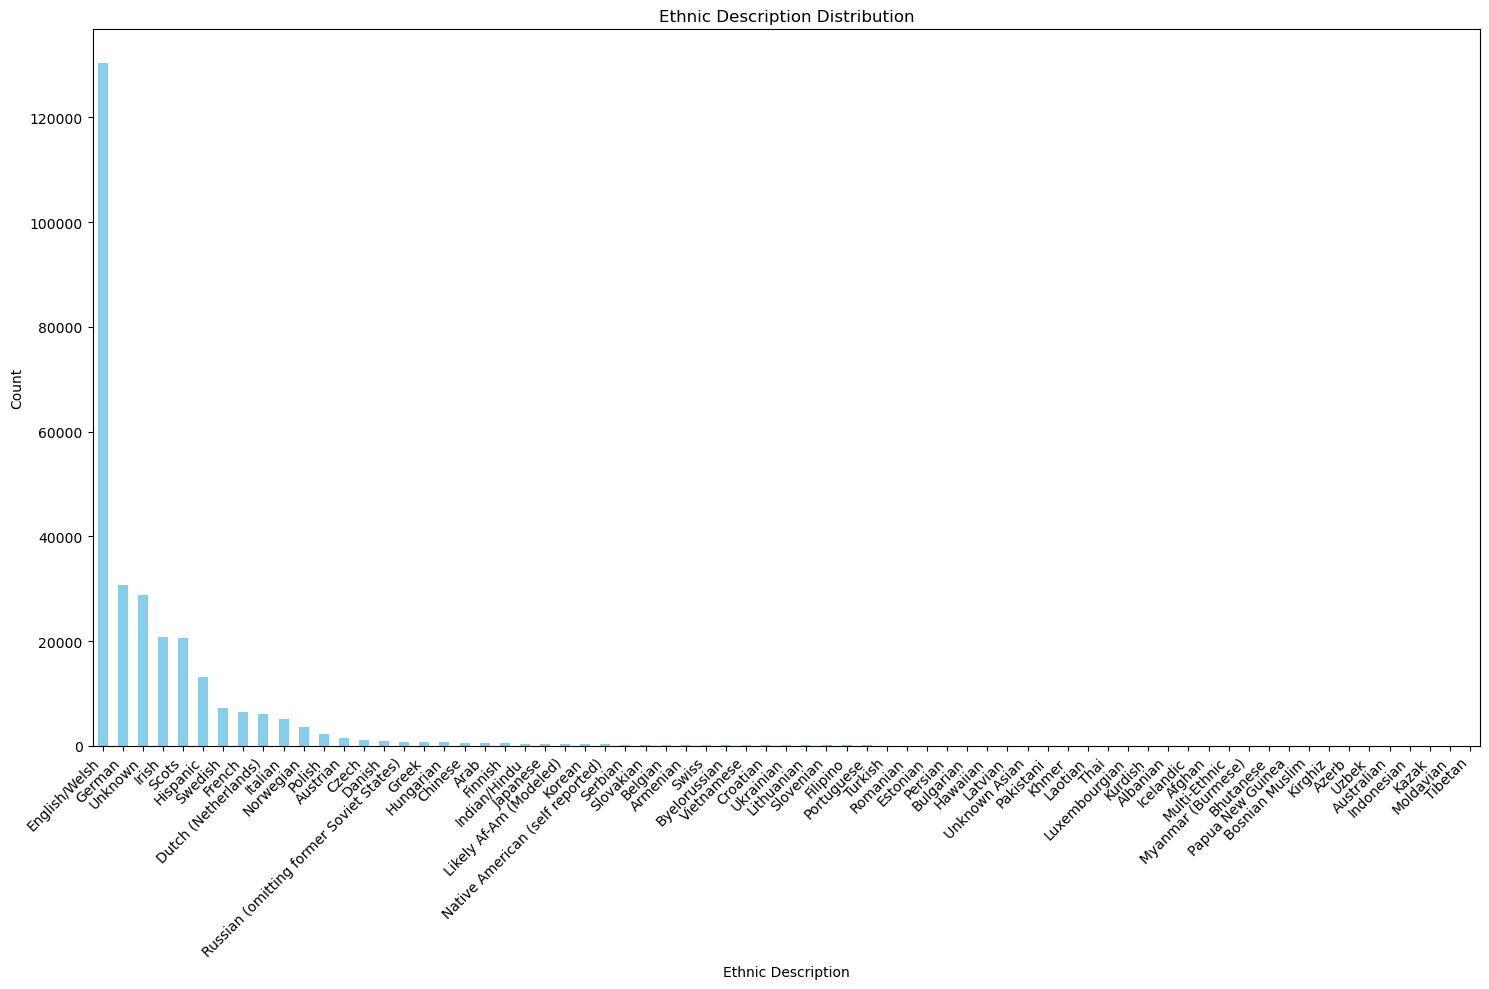

In [7]:
# graph counts of voters for each ethnic group

import matplotlib.pyplot as plt 
ethnic_counts = voter_data_pandas['Ethnic_Description'].value_counts()
plt.figure(figsize=(15, 10))
ethnic_counts.plot(kind='bar', color='skyblue')
plt.title('Ethnic Description Distribution')
plt.xlabel('Ethnic Description')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

This bar chart presents the distribution of voters by ethnicity in Wyoming. It's evident that the majority of ethnic groups have less than 20,000 individuals registered to vote. To condense the data for better performance and readability, we have grouped various ethnicities into broader categories. These include 'Other' for an union of less represented ethnicities, 'Asian' which combines all voters of Asian descent, 'Native American & Pacific Islander' for voters from these backgrounds, and 'Other European' for voters of various European origins not listed separately. 

In [8]:
import pandas as pd

# Create a new DataFrame with the 'Ethnicity' column replaced
voter_data_pandas_newnames = voter_data_pandas.replace({"Ethnic_Description": {
    "None": "Other",
    "Korean": "Asian",
    "Vietnamese": "Asian",
    "Japanese": "Asian",
    "Indian/Hindu": "Asian",
    "Likely Af-Am (Modeled)": "Other",
    "Thai": "Asian",
    "Native American (self-reported)": "Native American & Pacific Islander",
    "Filipino": "Asian",
    "Chinese": "Asian",
    "Myanmar (Burmese)": "Asian",
    "Pakistani": "Asian",
    "Unknown Asian": "Asian",
    "Khmer": "Asian",
    "Multi-Ethnic": "Other",
    'Papua New Guinea':'Other',
    'Australian':'Other', 
    "Indonesian": "Asian",
    "Kirghiz": "Asian",
    "Laotian": "Asian",
    "Tibetan": "Asian", 
    "Kazak": "Asian", 
    "Uzbek": "Asian", 
    "Armenian": "Asian",
    'Afghan':'Asian', 
    'Bhutanese':'Asian', 
    "Native American & Pacific Islander": "Native American & Pacific Islander", 
    'Hawaiian': "Native American & Pacific Islander",
    'Native American (self reported)':"Native American & Pacific Islander", 
    'Serbian':'Other European', 
    'Slovakian':'Other European', 
    'Belgian':'Other European', 
    'Swiss':'Other European', 
    'Byelorussian':'Other European', 
    'Croatian':'Other European', 
    'Ukrainian':'Other European', 
    'Lithuanian':'Other European', 
    'Slovenian':'Other European', 
    'Belgian':'Other European', 
    'Portuguese':'Other European', 
    'Turkish':'Other European', 
    'Romanian':'Other European', 
    'Estonian':'Other European', 
    'Persian':'Other European', 
    'Bulgarian':'Other European', 
    'Latvian':'Other European',
    'Luxembourgian':'Other European',
    'Kurdish':'Other European',
    'Albanian':'Other European',
    'Icelandic':'Other European', 
    'Bosnian Muslim':'Other European', 
    'Moldavian':'Other European', 
    "Azerb": "Other European",
    "Austrian": "Other European", 
    "Czech": "Other European",
    "Danish": "Other European",
    "Greek": "Other European",
    "Hungarian": "Other European",
    "Arab": "Asian",
    "Finnish": "Other European",
}})

# Display the modified DataFrame
voter_data_pandas_newnames

,HH_Income_Amount,Home_Value,County,Ethnic_Description,Voters_Gender,Voters_Active,Parties_Description
0,47000.0,253332.0,ALBANY,Irish,M,I,Libertarian
1,46718.0,177015.0,ALBANY,English/Welsh,M,I,Republican
2,6000.0,287499.0,ALBANY,Irish,F,I,Democratic
3,20832.0,287499.0,ALBANY,English/Welsh,M,I,Republican
4,85000.0,241936.0,ALBANY,Unknown,F,I,Non-Partisan
...,...,...,...,...,...,...,...
287031,61764.0,104629.0,WESTON,English/Welsh,M,A,Republican
287032,7000.0,53724.0,WESTON,German,F,A,Republican
287033,9000.0,101065.0,WESTON,Unknown,F,A,Republican
287034,61764.0,87500.0,WESTON,English/Welsh,M,A,Republican


### Distribution of the Voter Counts by Combined Ethnicity 

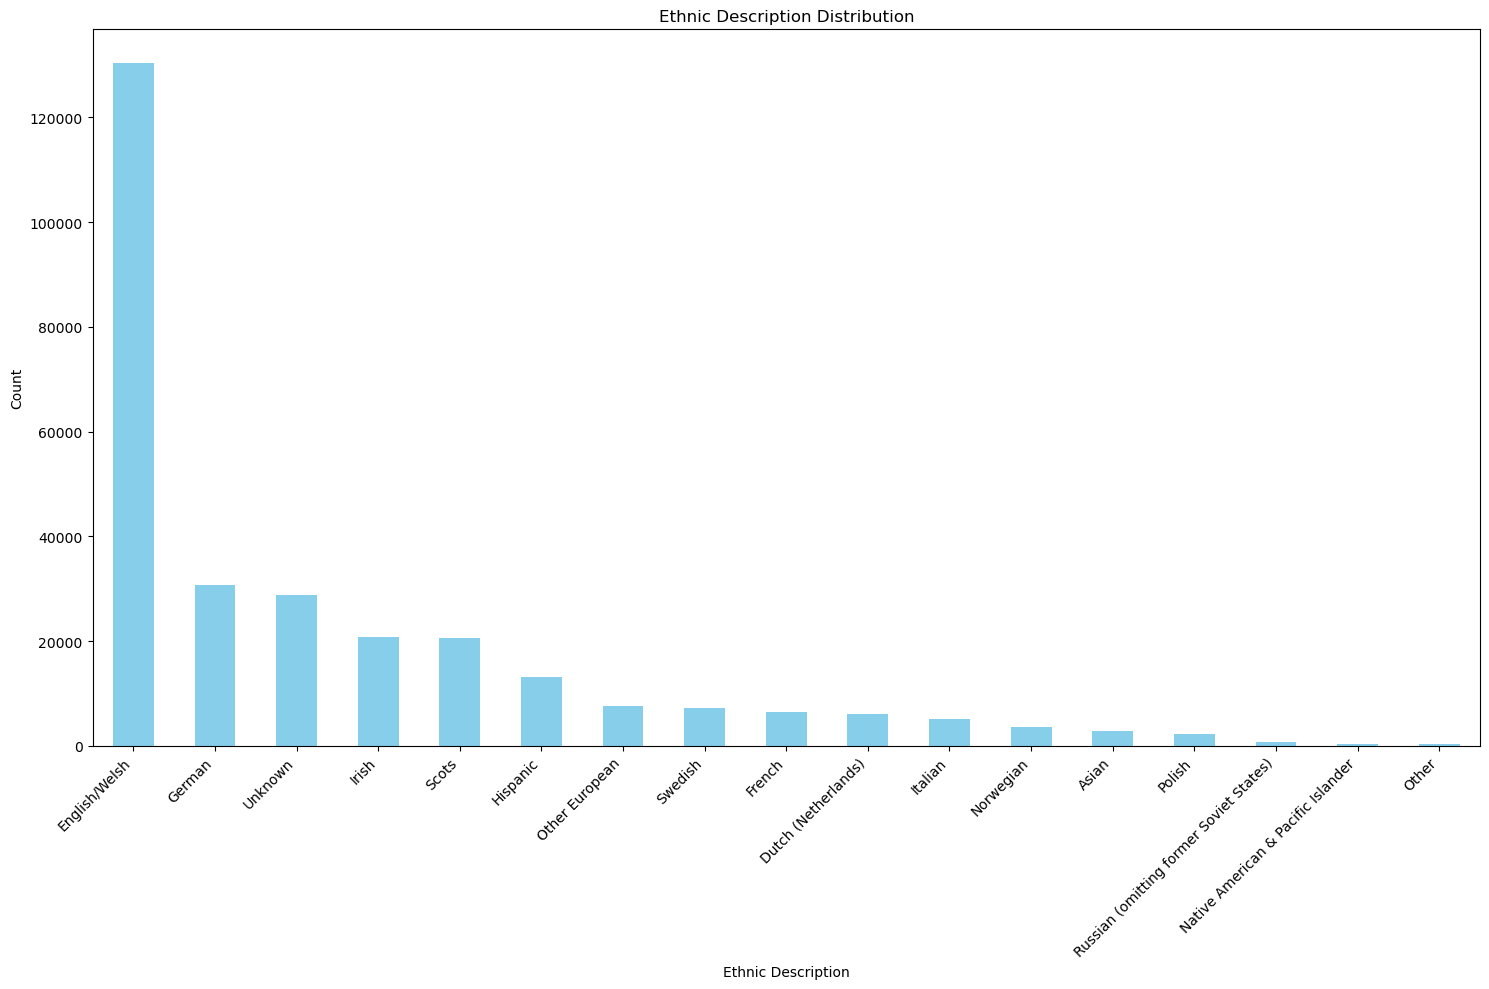

In [9]:
# graph counts of voters for each ethnic group

import matplotlib.pyplot as plt 
ethnic_counts = voter_data_pandas_newnames['Ethnic_Description'].value_counts()
plt.figure(figsize=(15, 10))
ethnic_counts.plot(kind='bar', color='skyblue')
plt.title('Ethnic Description Distribution')
plt.xlabel('Ethnic Description')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

This bar chart represents the ethnic composition of registered voters in Wyoming. We can see that the English/Welsh demographic constitutes the largest ethnic group in Wyoming, representing around 130,000 individuals. This significant majority suggests that the English/Welsh demographic could have a substantial impact on election outcomes and voter turnout patterns due to their sheer numbers. In contrast, other ethnic groups, including Hispanic, Other European, Asian, and Native American & Pacific Islander, represent smaller portions of the electorate.

Given this distribution, one may infer that political campaigns and policies with strong resonance within the English/Welish community could sway overall voter turnout more effectively than those targeting smaller ethnic groups. However, it is also essential to consider the potential of mobilization efforts within these smaller groups. Even though they represent a smaller share of the voter base, targeted engagement strategies could lead to proportional increases in turnout, possibly affecting election margins, particularly in close races.

In [10]:
# transform the Voters_Active column into 1 as active and 0 as inactive
voter_data_pandas_proportion = voter_data_pandas_newnames.copy()
voter_data_pandas_proportion["Voters_Active"] = voter_data_pandas_proportion["Voters_Active"].replace({'A': 1, 'I': 0})

# calculate the proportion of active voters for each ethnic group
grouped_ethnicity_df = voter_data_pandas_proportion.groupby('Ethnic_Description')["Voters_Active"].mean().reset_index()
grouped_ethnicity_df.rename(columns={'Voters_Active': 'Proportion_Active'}, inplace=True)
grouped_ethnicity_df = grouped_ethnicity_df.sort_values(by='Proportion_Active', ascending=False)
grouped_ethnicity_df

,Ethnic_Description,Proportion_Active
8,Native American & Pacific Islander,0.997085
12,Polish,0.987711
13,Russian (omitting former Soviet States),0.986076
1,Dutch (Netherlands),0.983561
7,Italian,0.982796
15,Swedish,0.982544
4,German,0.982138
11,Other European,0.982068
10,Other,0.982036
3,French,0.981762


## Proportion of Active Voters by Ethnicity

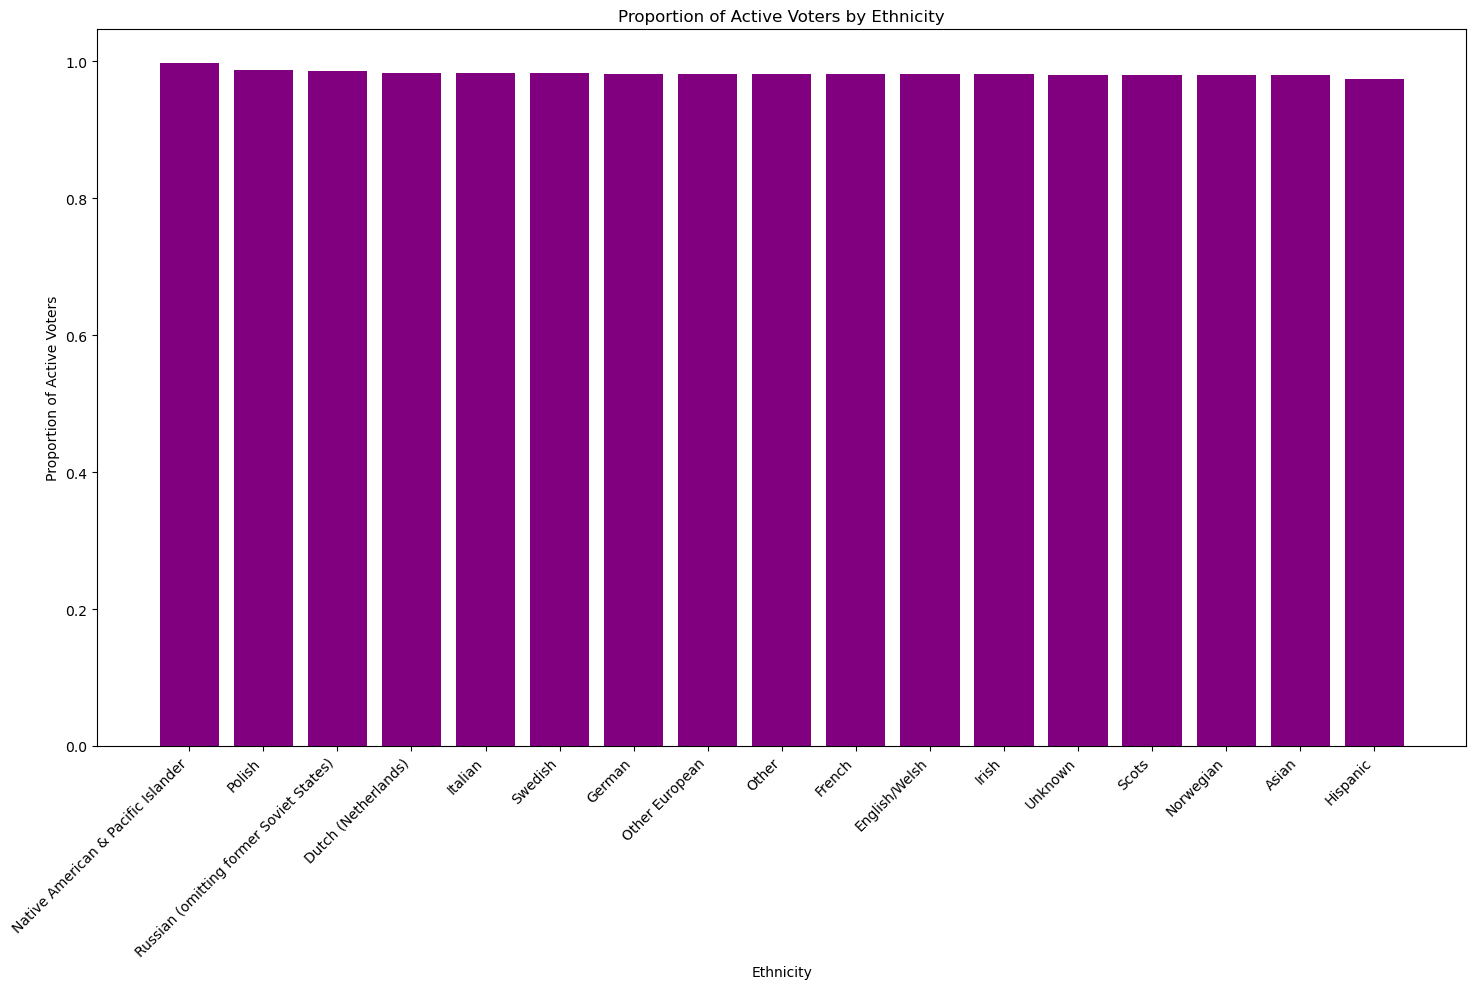

In [11]:
import matplotlib.pyplot as plt

# Create a bar graph
plt.figure(figsize=(15, 10))
plt.bar(grouped_ethnicity_df['Ethnic_Description'], grouped_ethnicity_df['Proportion_Active'], color='purple')
plt.title('Proportion of Active Voters by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Proportion of Active Voters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the bar chart, we noticed a remarkably high level of active voter engagement across all ethnic groups in Wyoming. Notably, the Native American & Pacific Islander category exhibits the highest proportion of active voters, at nearly 99.7%, but active voter rates among other ethnicities are also impressively high, with the Arab category displaying the lowest yet still substantial turnout at approximately 96.4%. The consistent active voter rates averaging around 98% across ethnicities may point to a potential selection bias in the data collection methodology. For example, if the data were gathered through voluntary response surveys, it is possible that active voters might be overrepresented in the sample.

The pattern of high voter engagement across diverse ethnic groups might mean that people from various ethnic backgrounds are just as, or even more, keen to vote, which warrants further investigation into the higher voter turnout rate. 

## County

### Distribution of Counties in Wyoming

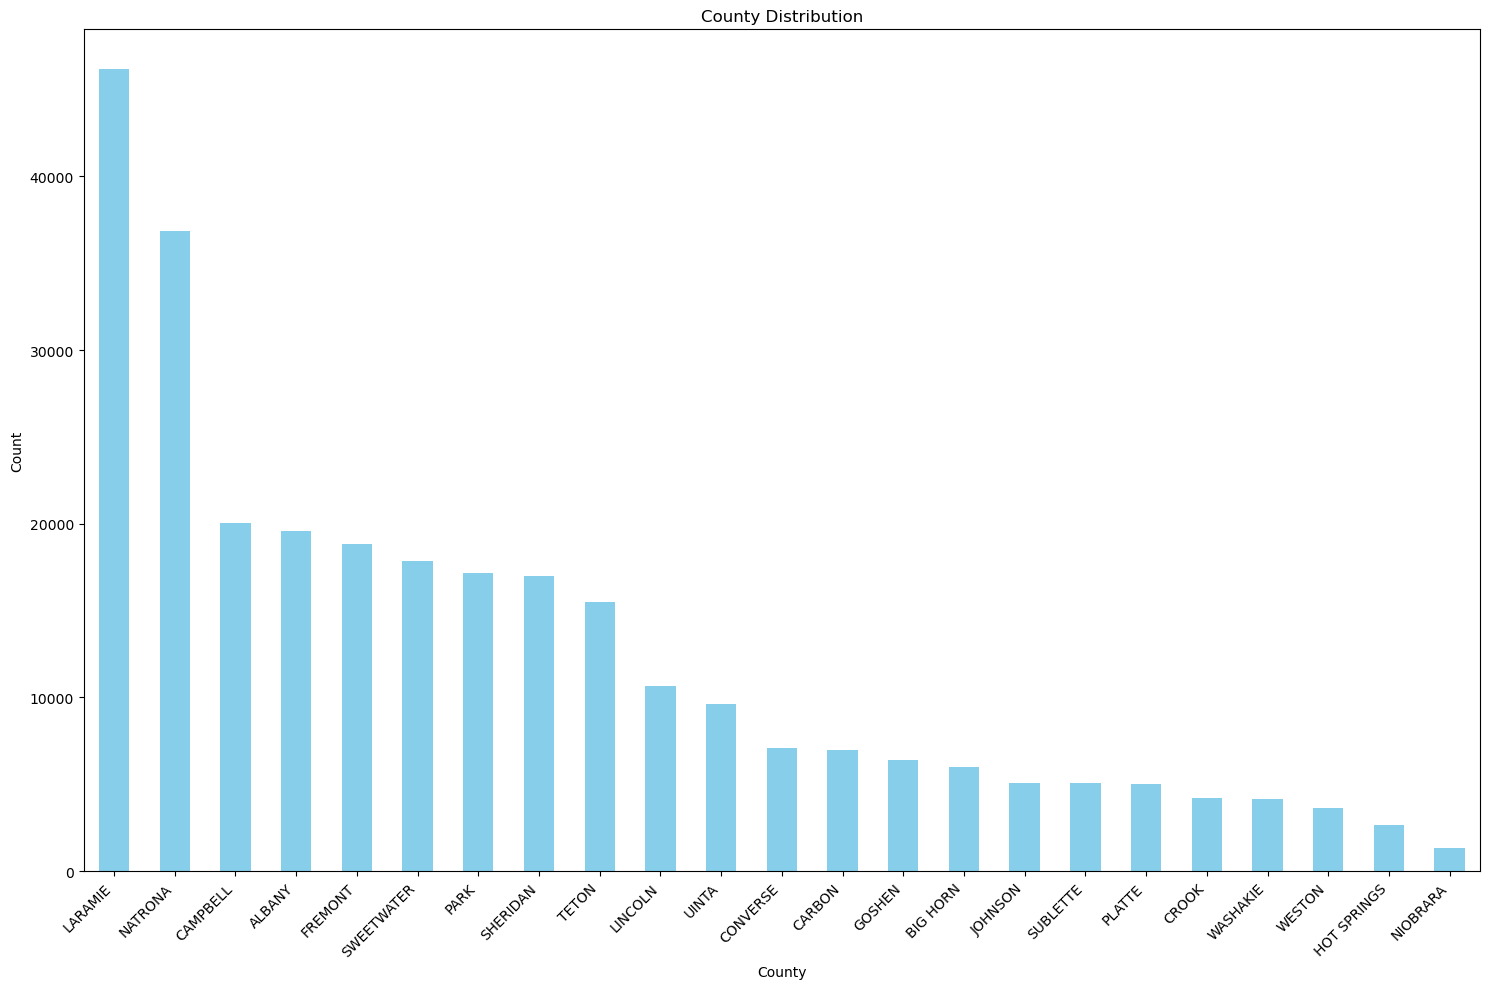

In [12]:
# graph counts of voters for counties 

import matplotlib.pyplot as plt 
ethnic_counts = voter_data_pandas['County'].value_counts()
plt.figure(figsize=(15, 10))
ethnic_counts.plot(kind='bar', color='skyblue')
plt.title('County Distribution')
plt.xlabel('County')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [13]:
# transform the Voters_Active column into 1 as active and 0 as inactive
voter_data_pandas_county_proportion = voter_data_pandas_newnames.copy()
voter_data_pandas_county_proportion["Voters_Active"] = voter_data_pandas_county_proportion["Voters_Active"].replace({'A': 1, 'I': 0})

# calculate the proportion of active voters for counties
grouped_county_df = voter_data_pandas_county_proportion.groupby('County')["Voters_Active"].mean().reset_index()
grouped_county_df.rename(columns={'Voters_Active': 'Proportion_Active'}, inplace=True)
grouped_county_df = grouped_county_df.sort_values(by='Proportion_Active', ascending=False)
grouped_county_df

,County,Proportion_Active
19,TETON,0.997484
17,SUBLETTE,0.996447
11,LINCOLN,0.993917
5,CROOK,0.992666
13,NIOBRARA,0.992647
3,CARBON,0.989112
15,PLATTE,0.988492
4,CONVERSE,0.988192
1,BIG HORN,0.987619
20,UINTA,0.987344


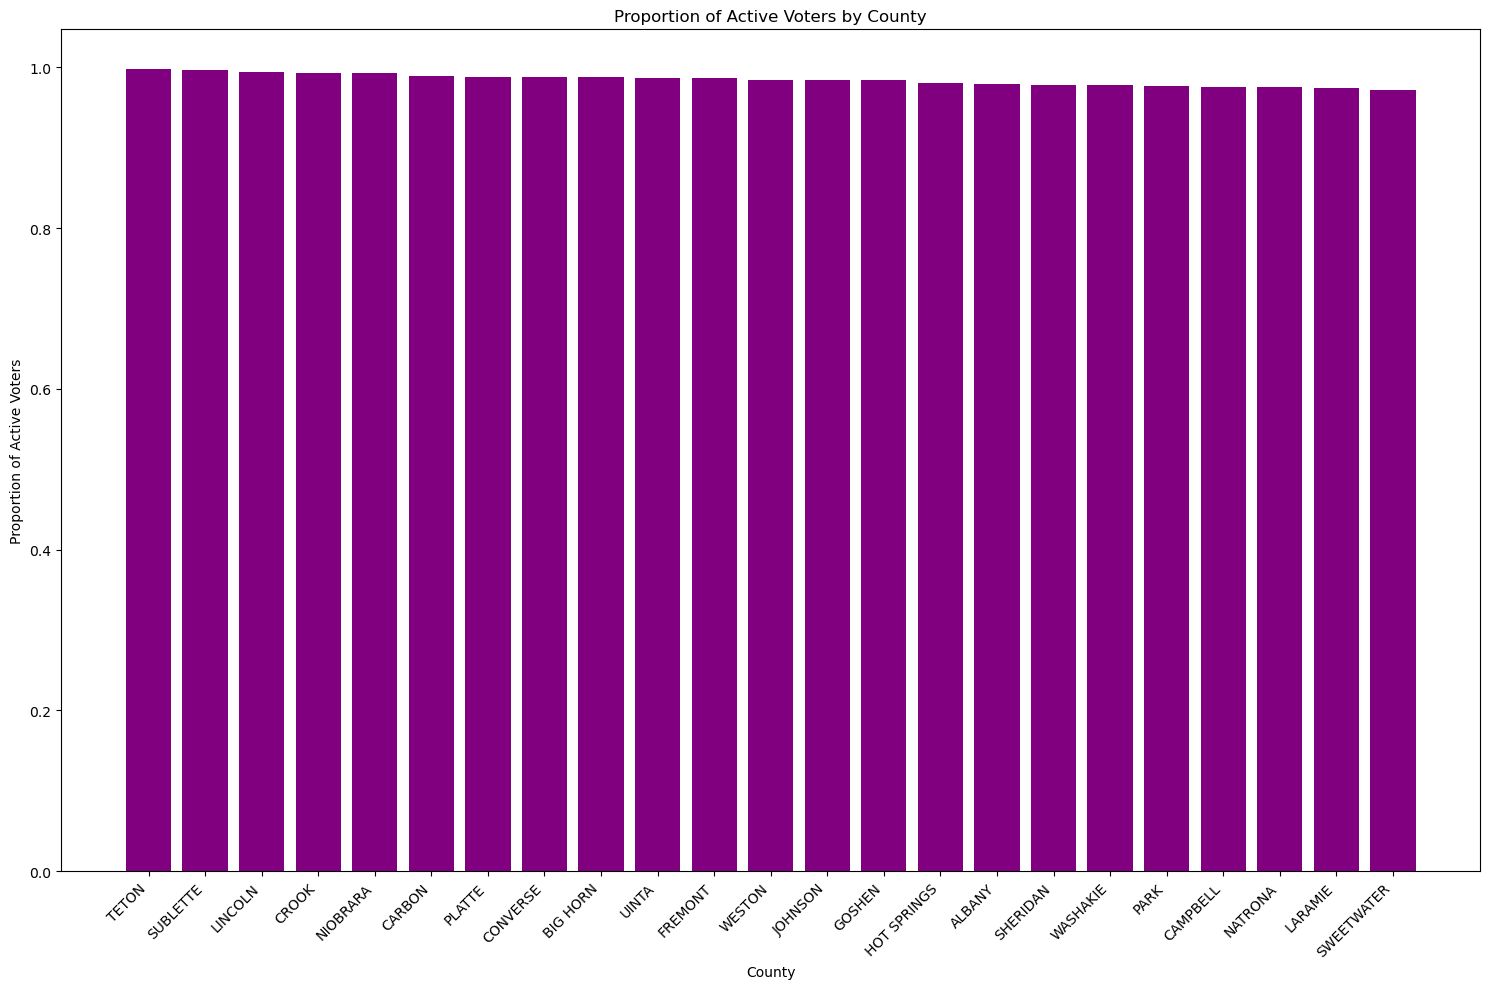

In [14]:
import matplotlib.pyplot as plt

# Create a bar graph
plt.figure(figsize=(15, 10))
plt.bar(grouped_county_df['County'], grouped_county_df['Proportion_Active'], color='purple')
plt.title('Proportion of Active Voters by County')
plt.xlabel('County')
plt.ylabel('Proportion of Active Voters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Although the counties Laramie and Natrona have the highest distribution count in Wyoming, Laramie and Natrona have one of the smallest proportion of active voters at an average of 0.975. Hot Springs and Niobrara county have the lowest distribution count in Wyoming, however Niobrara has one of the highest voter turnouts with Hot Springs close to the median turnout of 0.975. The results seem to be contradictory, however this reasons may be due to tighter-knit community cohesion among smaller counties which may increase political engagement. Moreover, the voting process and targeted campaigning in smaller counties may be easier and more cost-effectiive possibly due to higher turnout in town hall meetings. 

## Income

### Income Distribution by Brackets

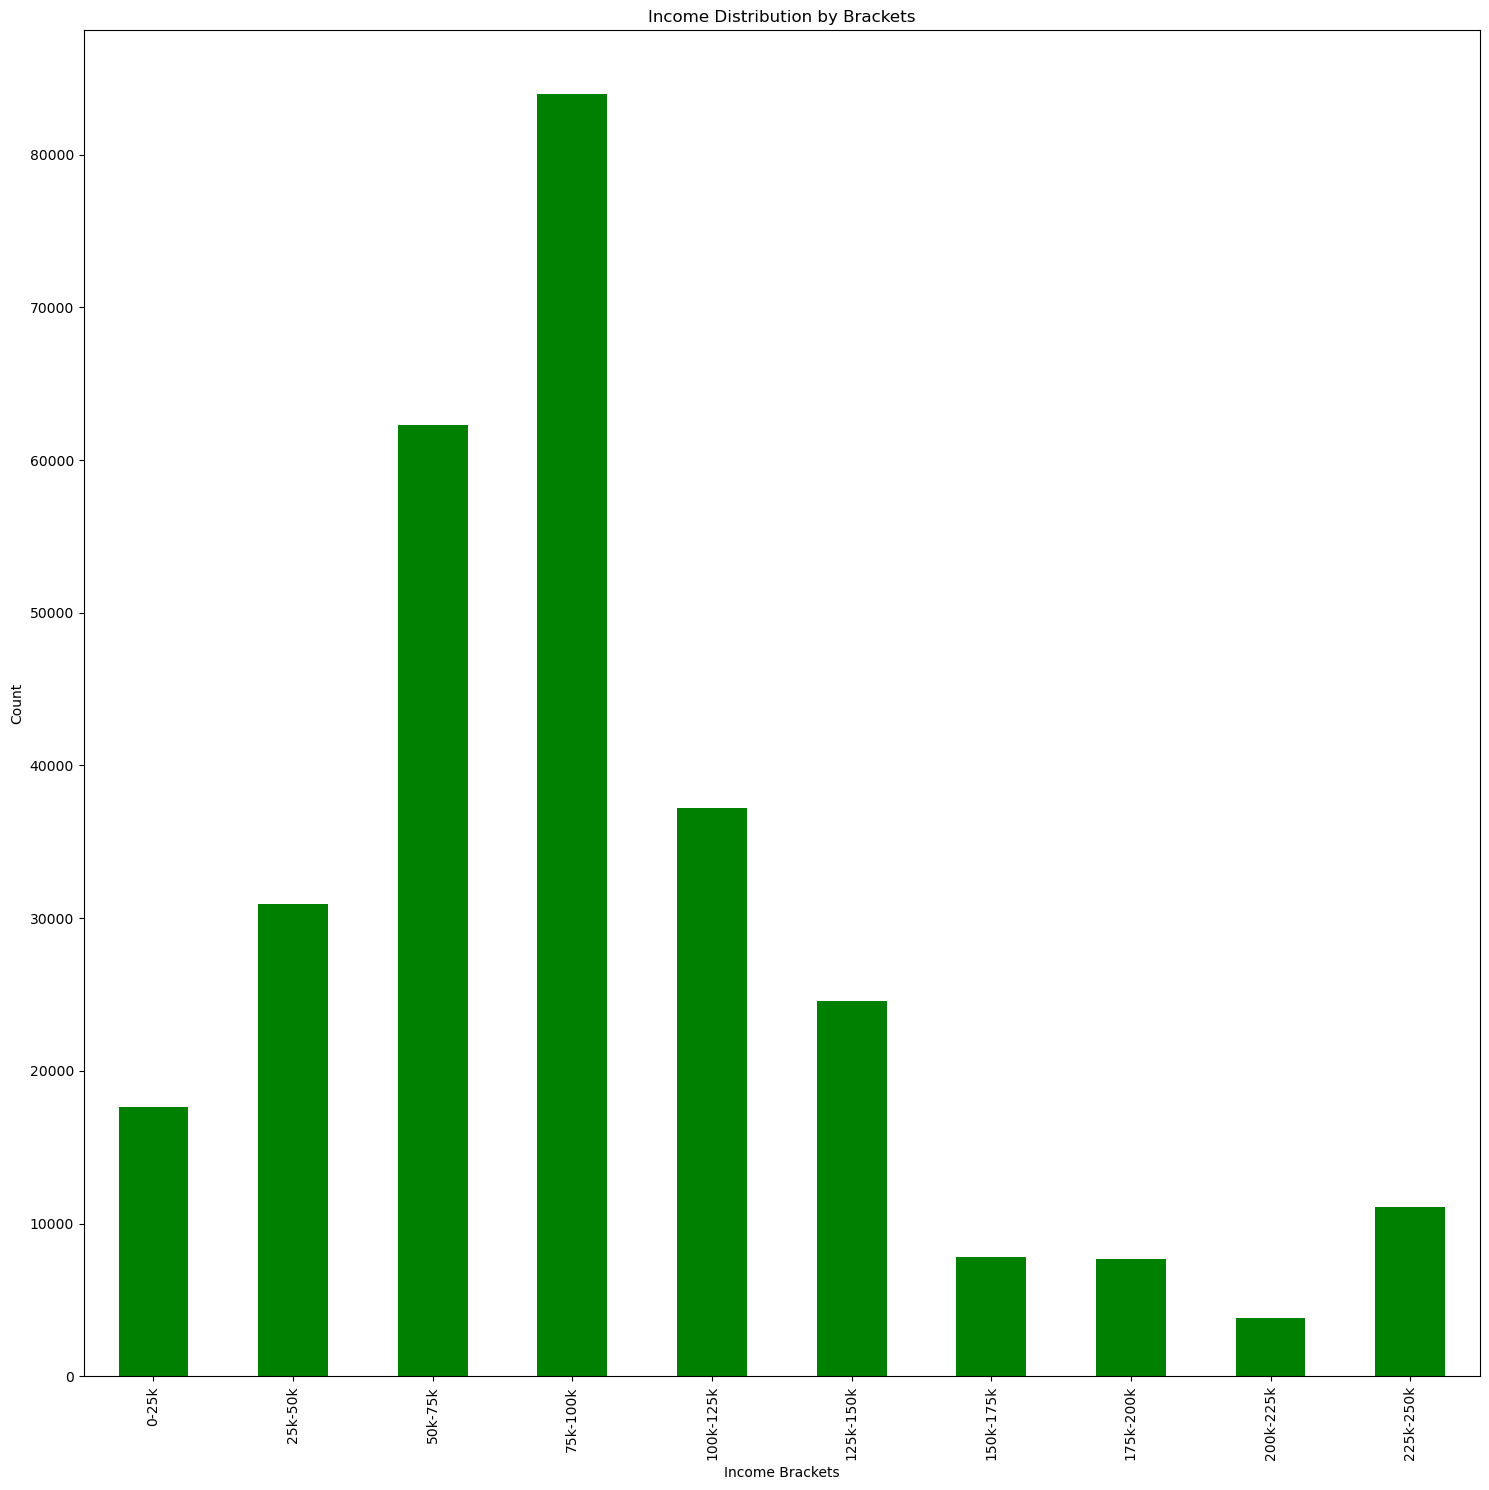

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

bins = [0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000]
labels = ['0-25k', '25k-50k', '50k-75k', '75k-100k', '100k-125k', '125k-150k', '150k-175k', '175k-200k', '200k-225k', '225k-250k']

voter_data_pandas['income_bracket'] = pd.cut(voter_data_pandas['HH_Income_Amount'], bins=bins, labels=labels)

#number of occurences
income_bracket_count = voter_data_pandas['income_bracket'].value_counts(sort=False)

#distribution of income brackets
plt.figure(figsize=(15, 15))
income_bracket_count.plot(kind='bar', color='green')
plt.title('Income Distribution by Brackets')
plt.xlabel('Income Brackets')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [16]:
voter_data_pandas['Voters_Active_Binary'] = voter_data_pandas['Voters_Active'].map({'I': 0, 'A': 1})

grouped_income_df = voter_data_pandas.groupby('income_bracket')['Voters_Active_Binary'].mean().reset_index()
grouped_income_df = grouped_income_df.sort_values(by='Voters_Active_Binary', ascending=False)
grouped_income_df

,income_bracket,Voters_Active_Binary
9,225k-250k,0.988308
7,175k-200k,0.987902
5,125k-150k,0.984934
8,200k-225k,0.984833
1,25k-50k,0.983510
6,150k-175k,0.983176
0,0-25k,0.981726
4,100k-125k,0.979595
3,75k-100k,0.979331
2,50k-75k,0.978993


It appears that the active voter participation tends to be greater for high income brackets. The top income group earning between 225k-250k shows the active voter participation being around 0.9883, suggesting a larger percentage of voters in this bracket are actively engaged compared to those in lower brackets, the lowest being 0.978 at 50k-75k. 

The observed trend indicates a positive correlation between higher income levels and increased voter turnout. This can be attributed to the greater access to resources and information that typically accompanies higher income. Moreover, there's a well-documented link between income and education levels, with higher educational achievements often leading to increased earnings and, consequently, higher levels of voter engagement.

However, it's important to note though that the the differences in voter participation across income groups are relatively minor. While income may be a factor, it seems that it does not create a drastic disparity in voting rates. Again, the pattern of high voter turnout may also reflect the methodology used in this data collection, particularly how voters are categorized as Inactive and Active within this dataset. 


### Active Voter Ratio by Income Distribution 

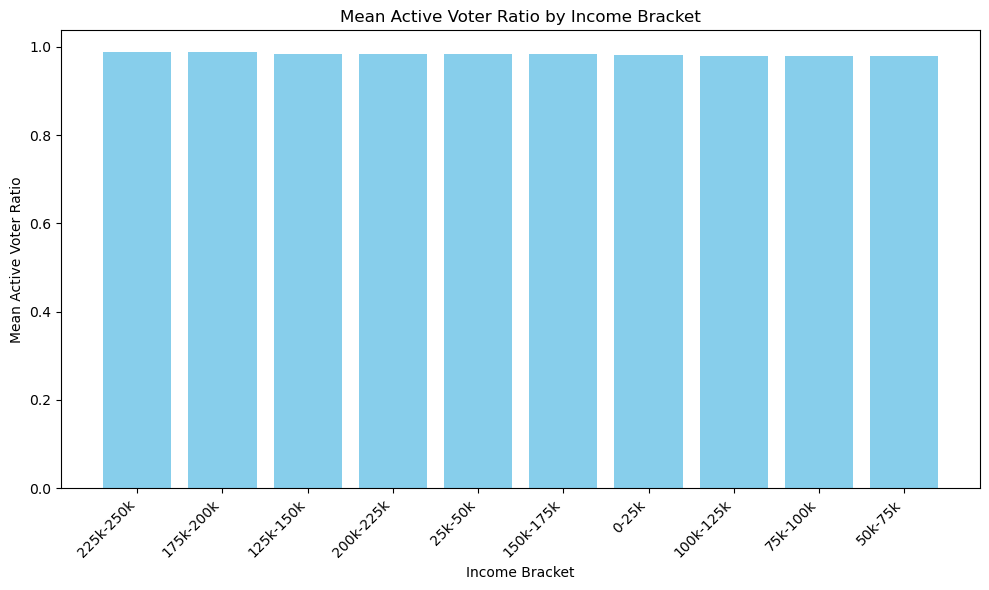

In [17]:
import matplotlib.pyplot as plt

#plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(grouped_income_df['income_bracket'], grouped_income_df['Voters_Active_Binary'], color='skyblue')

plt.xlabel('Income Bracket')
plt.ylabel('Mean Active Voter Ratio')
plt.title('Mean Active Voter Ratio by Income Bracket')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Comparing the Relationship between Household Income, Home Value, and Voter Turnout

/tmp/ipykernel_281746/4034533678.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


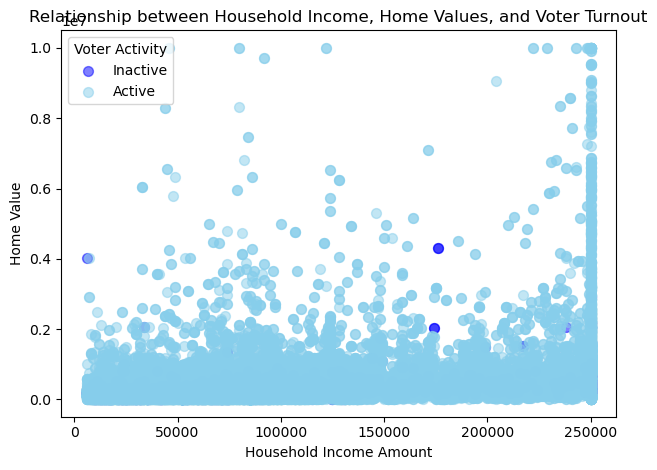

In [18]:
import matplotlib.pyplot as plt

#categorize by colors
colors = ['blue', 'skyblue']

for i, category in enumerate(['Inactive', 'Active']):
    subset = voter_data_pandas[voter_data_pandas['Voters_Active_Binary'] == i]
    plt.scatter(subset['HH_Income_Amount'], subset['Home_Value'], 
                s=50, c=colors[i], label=category, alpha=0.5)

#legend
plt.legend(title='Voter Activity')

#label
plt.xlabel('Household Income Amount')
plt.ylabel('Home Value')
plt.title('Relationship between Household Income, Home Values, and Voter Turnout')

plt.tight_layout()

plt.show()

When examining the correlation between household income and home value, it is evident that a large proportion of voters engage actively in the process. The distribution of home values compared to household income shows the widest spread, with values ranging from 0.0 to 1.0. This range is consistent with what one might logically anticipate, demonstrating a wide disparity in home values across different income brackets. 

## Gender 

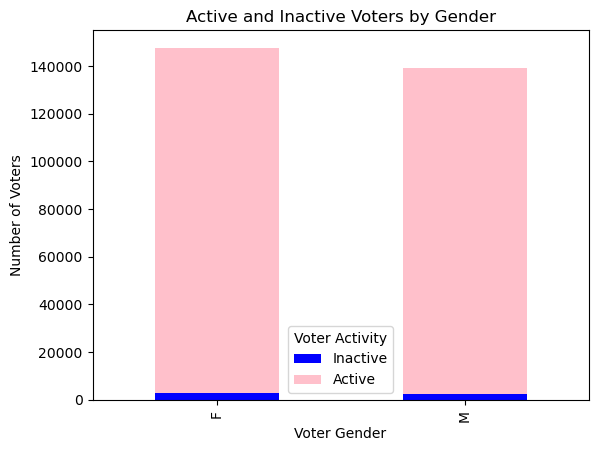

In [19]:
#stacked bar chart for gender

counts = voter_data_pandas.groupby(['Voters_Gender', 'Voters_Active_Binary']).size().unstack()

counts.plot(kind='bar', stacked=True, color=['blue', 'pink'])

plt.xlabel('Voter Gender')
plt.ylabel('Number of Voters')
plt.title('Active and Inactive Voters by Gender')

plt.legend(title='Voter Activity', labels=['Inactive', 'Active'])

plt.show()

The stacked bar chart shows that the female voter count is marginally higher, approximately 145,000, compared to the male voter count, which is slightly under 140,000. Once again, the chart indicates a relatively low proportion of inactive voters.

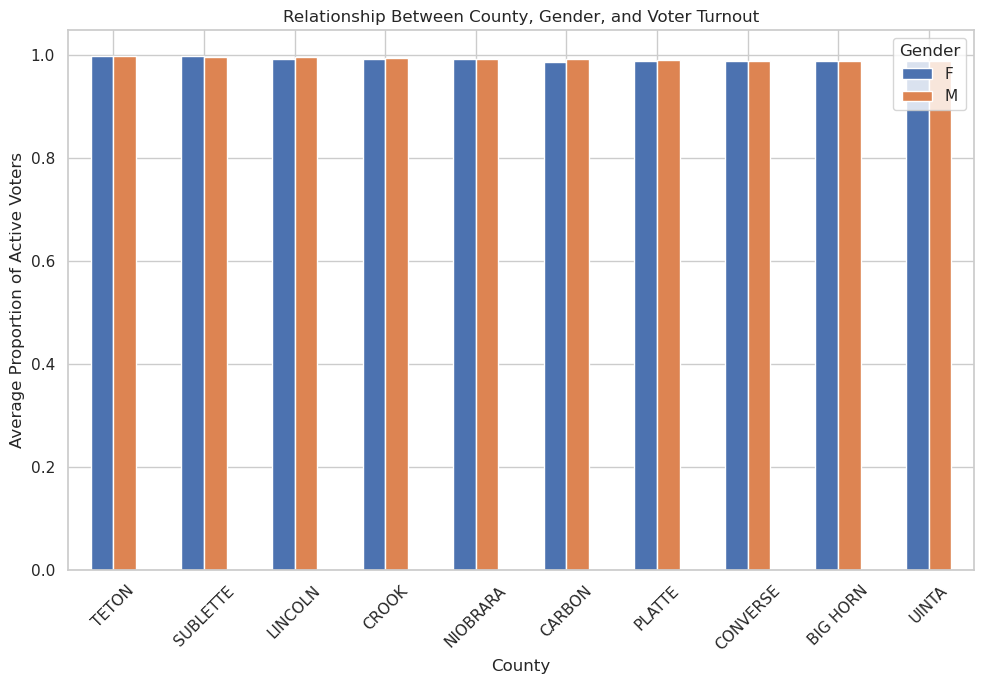

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

voter_data_pandas["Voters_Active"] = voter_data_pandas["Voters_Active"].replace({'A': 1, 'I': 0})

county_gender_turnout = voter_data_pandas.groupby(['County', 'Voters_Gender'])['Voters_Active'].mean().unstack()

sns.set(style="whitegrid")

#plot only the top 10 counties
top_counties = county_gender_turnout.sum(axis=1).nlargest(10).index
county_gender_turnout = county_gender_turnout.loc[top_counties]

#grouped bar chart
county_gender_turnout.plot(kind='bar', stacked=False, figsize=(10, 7))

plt.title('Relationship Between County, Gender, and Voter Turnout')
plt.xlabel('County')
plt.ylabel('Average Proportion of Active Voters')

plt.xticks(rotation=45)

plt.legend(title='Gender')

plt.tight_layout()
plt.show()



The grouped bar chart, which compares active voter participation by gender across the top 10 counties, reveals that the average rate of active voters consistently hovers around 0.98. It's observed that Teton, Big Horn, and Uinta counties display an equal distribution of male and female voters. Meanwhile, Sublette and Niobrara counties exhibit a greater proportion of female voters compared to male voters.

Now that we have finished our EDA of the data, we can move on to applying our models.

# Modeling - Active Voters

### One Hot Encoding

Before we can apply any of the models on our dataset, we must prepare our PySpark dataframe in an acceptable format, using one hot encoding. The goal of one hot encoding is to convert the categorical variables in a dataset to a format that is readable by machine learning algorithms. 

For now, we are going to one hot encode the columns 'County' and 'Ethnic_Description.' We also modified 'Voters_Gender' to 'Voters_Male,' which represents if the individual is male (1) or female (0). For our response variable 'Voters_Active,' we changed values of "A" to be 1, representing that the voter is active, and 0 otherwise, indicating the voter is inactive. We will format 'Parties_Description' when we are looking at the models that predict an active voter's political party affiliation. Below is the process of converting to our dataframe to be one hot encoded:

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

voter_data_encoded = voter_data.withColumnRenamed("Voters_Gender", "Voters_Male")
# Replace 'M' with 1 and 0 elsewise in the 'Voters_Male' column
voter_data_encoded = voter_data_encoded.withColumn('Voters_Male',
                           when(col('Voters_Male') == 'M', 1)
                           .otherwise(0))

# Replace 'A' with 1 and 0 elsewise in the 'Voters_Active' column
voter_data_encoded = voter_data_encoded.withColumn('Voters_Active',
                           when(col('Voters_Active') == 'A', 1)
                           .otherwise(0))

# Indexers for County and Ethnic_Description columns
county_indexer = StringIndexer(inputCol='County', outputCol='CountyIndex')
ethnic_indexer = StringIndexer(inputCol='Ethnic_Description', outputCol='EthnicIndex')

# One-hot encoders for County and Ethnic_Description columns
county_encoder = OneHotEncoder(inputCol='CountyIndex', outputCol='CountyVec')
ethnic_encoder = OneHotEncoder(inputCol='EthnicIndex', outputCol='EthnicVec')

# Define the pipeline
pipeline = Pipeline(stages=[county_indexer, ethnic_indexer, county_encoder, ethnic_encoder])

# Fit and transform the data using the pipeline
voter_data_encoded = pipeline.fit(voter_data_encoded).transform(voter_data_encoded)

# Drop the original County and Ethnic_Description columns
voter_data_encoded = voter_data_encoded.drop('County', 'Ethnic_Description', 'CountyIndex', 'EthnicIndex')

voter_data_encoded.show(10)

+----------------+----------+-----------+-------------+-------------------+--------------+--------------+
|HH_Income_Amount|Home_Value|Voters_Male|Voters_Active|Parties_Description|     CountyVec|     EthnicVec|
+----------------+----------+-----------+-------------+-------------------+--------------+--------------+
|         47000.0|  253332.0|          1|            0|        Libertarian|(22,[3],[1.0])|(68,[3],[1.0])|
|         46718.0|  177015.0|          1|            0|         Republican|(22,[3],[1.0])|(68,[0],[1.0])|
|          6000.0|  287499.0|          0|            0|         Democratic|(22,[3],[1.0])|(68,[3],[1.0])|
|         20832.0|  287499.0|          1|            0|         Republican|(22,[3],[1.0])|(68,[0],[1.0])|
|         85000.0|  241936.0|          0|            0|       Non-Partisan|(22,[3],[1.0])|(68,[2],[1.0])|
|         69230.0|  189582.0|          1|            0|         Democratic|(22,[3],[1.0])|(68,[2],[1.0])|
|         69230.0|  189582.0|          0|     

As seen by our encoded data frame, we see that our 'County' column has been replaced by a sparse values in our new 'CountyVec' and 'EthnicVec' columns. The first value in the tuple of these columns represents the number of possible features that 'County' and 'Ethnic_Description' took on. The second value represents the index of a particular value that is taken on by these columns. The third value of '1' represents the occurence of the value in these columns. For example, (68,[3],[1.0]) represents a specific ethnicity, and (68,[0],[1.0]) represents another ethnicity. This type of format is supported by the machine learning libraries in PySpark.

Next, we will apply our machine learning models. We have chosen to use four classification models:
- Logistic Regression
- Support Vector Machines
- Random Forest Classification 
- Gradient Boosting Trees

For each model we are fitting to our data, we are trying to predict whether a voter is "active" or "inactive". We follow this same procedure for every model we run:

- Spliting the data into training and testing sets
- Fitting the model on our data w/ chosen paramter(s)
- Analysis the accuracy and ROC scores

### Logistic Regression

Logistic regression can be used for classification and is very easily interpretable. Our first step is to encode active voters with the value of '1' and inactive voters with the value of '0.' Then, we can go on and apply the model.

In [22]:
voter_data_pandas_encode = voter_data_pandas_2.copy()
voter_data_pandas_encode["Voters_Active"] = voter_data_pandas_encode["Voters_Active"].replace({'A': 1, 'I': 0})

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# create dummy variables
encoded_columns = pd.get_dummies(voter_data_pandas_encode[['County', 'Ethnic_Description', 'Voters_Gender']])
df_encoded = pd.concat([voter_data_pandas_encode.drop(columns=['County', 'Ethnic_Description', 'Voters_Gender', "Parties_Description"]), encoded_columns], axis=1)
X = df_encoded.drop(columns=["Voters_Active"])
y = df_encoded["Voters_Active"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on test data
predictions = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# calculate ROC AUC score
roc_auc = roc_auc_score(y_test, predictions)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9814485785953178
ROC AUC Score: 0.5


The Accuracy of this regression is .98 which is fairly high. This could be due to the fact that we obseved such a high amount of active voters. As mentioned before, the proportion of active voters is almost 1 across all ethnicities, income brackets, counties, etc. Thus, it would not be difficult for the model to predict whether a voter is active or inactive. The ROC of .5 suggests that the model's performance is no better than random guessing, as an ROC of 1 would indicate a perfect classifier. 

#### Examining only income as a predictor

In the EDA we noticed a correlation between income and high voter activity. Thus, we will be dropping the other columns and will be predicting how well the income and home value predict voter activity.

In [24]:
# Logistic regression of income, geographic location, ethnicity, and gender predicting general election
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

df_2 = voter_data_pandas_encode.drop(columns=['County', 'Ethnic_Description', 'Voters_Gender', "Parties_Description"])
X_2 = df_2.drop(columns=["Voters_Active"])
y_2 = df_2[["Voters_Active"]]

# Split the data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# Create and fit logistic regression model
model_2 = LogisticRegression()
model_2.fit(X_train_2, y_train_2)

# Make predictions on test data
predictions_2 = model_2.predict(X_test_2)

# Calculating accuracy
accuracy_2 = accuracy_score(y_test_2, predictions_2)
print("Accuracy:", accuracy_2)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, predictions)
print("ROC AUC Score:", roc_auc)

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9814485785953178
ROC AUC Score: 0.5


Even after dropping the other columns, the Accuracy and ROC are the same. This makes sense, as the proportion of active voters is generally high throughout all of the predictor variables, making it a minimal change in accuracy and model performance when certain predictor variables are removed. 

### Support Vector Machines

Support vector machines is a type of ML algorithm that is great for binary classification, robust to overfitting, memory efficient, and easy to interpret. We thought that it would be a great first model to try out for our data to predict whether voters or "active" or "inactive" in the state of Wyoming. 

In running this model, we chose to give a regularization penalty of 0.2, as that is when the model performed its best:

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assemble the feature vector
feature_columns = ['HH_Income_Amount','Home_Value','Voters_Male',
                   'CountyVec','EthnicVec']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
voter_data_assembled = assembler.transform(voter_data_encoded)

# Split the data into training and test sets
train_data, test_data = voter_data_assembled.randomSplit([0.8, 0.2], seed=123)

# Train the SVM model
svm = LinearSVC(featuresCol='features', labelCol='Voters_Active', regParam=0.2) # choose 0.2
svm_model = svm.fit(train_data)

# Make predictions on the test data
predictions = svm_model.transform(test_data)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Voters_Active', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# Print accuracy
print("Accuracy:", accuracy)

# Area under ROC
evaluator = BinaryClassificationEvaluator(labelCol='Voters_Active')
area_under_roc = evaluator.evaluate(predictions)
print("Area Under ROC:", area_under_roc)

Accuracy: 0.9818506396905683


Area Under ROC: 0.6134016436415894


The SVM model had a very high accuracy, and indicated that it correctley predicted whether a voter was "active" or "inactive" 98% of the time. The area under the ROC was about 61%, indicating that the model had a moderate ability to discriminate between "active" voters and "inactive" voters. Although the model performs well at predicting whether voters are "active" or "inactive" overall, its capacity to effectively distinguish between these two categories was not as high.

### Random Forest Classification

After running the SVMs, we thought that Random Forest Classification might be a better model for predicting voter activeness. Random Forest Classification is known for high accuracy, reducing overfitting, handling large dataset, and is robust to outliers. The tree like nature of the model is also able to capture complex interactions between the features, which could help us in hvaing a better area under ROC score. After running the model a number of times, we found that 15 trees and a maximum amaount of bins value of 40 yielded the best results.

In [10]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Define feature columns and label column
feature_columns = ['HH_Income_Amount', 'Home_Value', 'Voters_Male', 'CountyVec', 'EthnicVec']
label_column = 'Voters_Active'

# Assuming 'voter_data_encoded' is your PySpark DataFrame

# Assemble feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(voter_data_encoded)

# Split data into training and test sets
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=123)

# Create and train Random Forest Classifier Model
rf = RandomForestClassifier(featuresCol='features', labelCol=label_column, numTrees=15, maxBins=40)
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate Model Performance
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='accuracy')
accuracy = evaluator_accuracy.evaluate(predictions)
print("Accuracy:", accuracy)

# Calculate ROC AUC
evaluator_roc = BinaryClassificationEvaluator(labelCol=label_column)
roc_auc = evaluator_roc.evaluate(predictions, {evaluator_roc.metricName: "areaUnderROC"})
print("Area Under ROC AUC:", roc_auc)


Accuracy: 0.9818506396905683


Area Under ROC AUC: 0.6079391653216034


Again, the accuracy was about 98%, but one thing that surprised us was that we were only able to achieve an area under the ROC of about 61%, which was not too different from our SVM model. Our Random Forest Classification Model had a moderate ability to discriminate between "active" voters and "inactive" voters. Due to this, we tried using Gradient Boosting Trees, hoping for better results.

### Gradient Boosting Trees

Gradient Boosting Trees is a technique that can be used to solve classification problems, such as this one. It works by combining multiple decision trees to create a robust model. In every iteration of the training, the performance of the model is increased by adding new trees to the current ensemble. Each new tree that is trained to correct the errors of the trees in the current ensemble. 

Like a Random Forest Trees, Gradient Boosting Trees have high accuracy, capture complex patterns, and are robust to overfitting. We thought it would be useful because of its ability to handle imbalanced data, as there are a much higher proportion of "active" voters compared to "inactive" voters. Also, since each tree that ias added learns from the errors of the current ensemble, we thought this might improve the model's performance.

After running this model several times, we decided that maxIter=15 and maxBins=60 were parameters that helped improve the model's performance by a sufficient amount.

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assemble the feature vector
feature_columns = ['HH_Income_Amount', 'Home_Value', 'Voters_Male', 'CountyVec', 'EthnicVec']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
voter_data_assembled = assembler.transform(voter_data_encoded)

# Split the data into training and test sets
train_data, test_data = voter_data_assembled.randomSplit([0.8, 0.2], seed=123)

# Train the Gradient Boosting Tree model
gbt = GBTClassifier(featuresCol='features', labelCol='Voters_Active', maxIter=15, maxBins=60)
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)

# Calculate accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Voters_Active', metricName='accuracy')
accuracy = evaluator_accuracy.evaluate(predictions)

# Print accuracy
print("Accuracy:", accuracy)

# Area under ROC
evaluator = BinaryClassificationEvaluator(labelCol='Voters_Active')
area_under_roc = evaluator.evaluate(predictions)
print("Area Under ROC:", area_under_roc)

Accuracy: 0.9819031450723699


Area Under ROC: 0.6431980964560804


The accuracy of this model was marginally higher than the Random Forest Classification model, but we did see an area under the ROC of about 0.643, which is about 0.04 higher than that of the Random Forest model. The Gradient Boosting Tree's ability to discriminate between "active" and "inactive" voters is still moderate, as 0.643 is still between 0.5 and 0.7. However, this model has performed this Gradient Boosting model has performed the best out of any three models we ran, having the highest accuracy and area under the ROC. Therefore, we will analyze this model further.

### Best Model - Gradient Boosting Trees

Since our Gradient Boosting Trees model performed the best out of the three, we will use it answer our first research question. Before doing so, we have created a plot of the feature importance of the model to show which features were the most influential to the model.

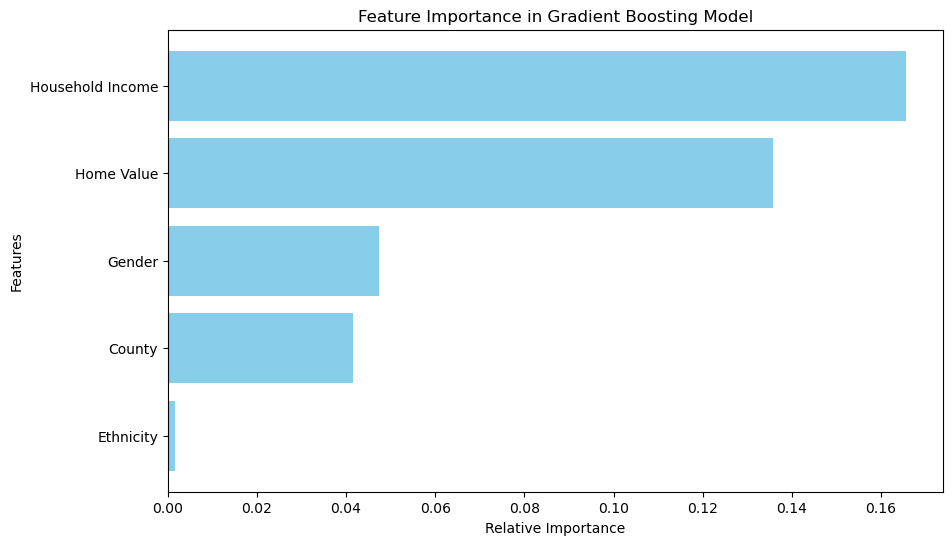

In [12]:
# Feature importance graph of the 'Gradient Boosting Model'
import matplotlib.pyplot as plt

# Get the feature names from the inputCols parameter of the VectorAssembler
feature_names = assembler.getInputCols()

# Get the feature importance values from the trained model
importance_values = gbt_model.featureImportances.toArray()

# Create a dictionary mapping feature names to importance values
feature_importance_map = dict(zip(feature_names, importance_values))

# Sort the feature importance map by importance values
sorted_feature_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Extract sorted feature names and importance values
sorted_features = [item[0] for item in sorted_feature_importance]
sorted_importance = [item[1] for item in sorted_feature_importance]

# Renaming the columns for display purposes
renamed_features = ['Household Income', 'Home Value', 'Gender', 'County', 'Ethnicity']

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(renamed_features, sorted_importance, color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Gradient Boosting Model')
plt.gca().invert_yaxis()  
plt.show()


For predicting whether a voter is "active" or "inactive" in the state of Wyoming, the feature importance graph shows that household income and home value were the highest in relative importance, while gender and county had some level of influence, and ethnicity did not contribute nearly as much as the other features. This is consistent with the explanatory data analysis that was conducted, where we found that household income and home value was highly correlated with voter activity. This makes sense because indviduals with more wealth may have higher access to information of political issues, canidates, and voting procedures. They also may have the ability to overcome barriers in voting, such as transportation. Generally speaking, it is likely that individuals with higher economic status are well educated, which could influence their civic engagement.

## Modeling - Party Classification

Next, we will try to predict party affiliation for active voters in the state of Wyoming. First, we will do some quick preprocessing and explanatory data analysis before running our models.

### Quick Preprocessing & EDA

We are only interested in voters that are active in the state of Wyoming, as the political party that they affiliate may be more true to their beliefs. Because of this, we have filtered our 'voter_data' dataset so that it only has voters that are active:

In [8]:
# Filtering for only active voters
voter_data_party = voter_data.filter(col("Voters_Active") != "I")
voter_data_party = voter_data.drop('Voters_Active')
voter_data_party.show(10)

+----------------+----------+------+------------------+-------------+-------------------+
|HH_Income_Amount|Home_Value|County|Ethnic_Description|Voters_Gender|Parties_Description|
+----------------+----------+------+------------------+-------------+-------------------+
|         47000.0|  253332.0|ALBANY|             Irish|            M|        Libertarian|
|         46718.0|  177015.0|ALBANY|     English/Welsh|            M|         Republican|
|          6000.0|  287499.0|ALBANY|             Irish|            F|         Democratic|
|         20832.0|  287499.0|ALBANY|     English/Welsh|            M|         Republican|
|         85000.0|  241936.0|ALBANY|           Unknown|            F|       Non-Partisan|
|         69230.0|  189582.0|ALBANY|           Unknown|            M|         Democratic|
|         69230.0|  189582.0|ALBANY|           Unknown|            F|         Democratic|
|        135000.0|  219999.0|ALBANY|     English/Welsh|            F|         Democratic|
|        1

Next, we will plot a bar plot to show the counts of each party. We want to visually see what party dominates the state, and also see if there are any parties beside 'Democratic' and 'Republican' worth noting.

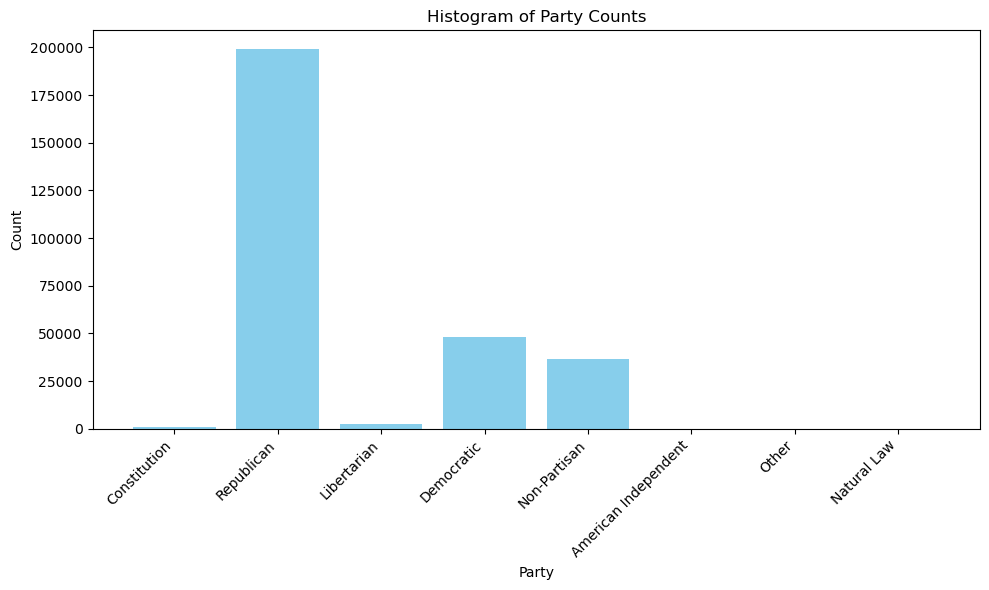

In [9]:
# Graph showing relative count of party for active voters

# Group by 'Parties_Description' and count the occurrences of each party
party_counts = voter_data_party.groupBy("Parties_Description").count()

# Convert the result to a list of tuples (party, count)
party_counts_list = [(row["Parties_Description"], row["count"]) for row in party_counts.collect()]

import matplotlib.pyplot as plt

# Convert the result to a list of tuples (party, count)
party_counts_list = [(row["Parties_Description"], row["count"]) for row in party_counts.collect()]

# Extract parties and counts
parties = [party for party, count in party_counts_list]
counts = [count for party, count in party_counts_list]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(parties, counts, color='skyblue')
plt.xlabel('Party')
plt.ylabel('Count')
plt.title('Histogram of Party Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


From this bar plot, we can see that Wyoming is a hugely Republican state. The counts of the Democratic party seem to be around 1/4 of the counts of the Republican party. For easy intepretation and in order to make use of certain models we knew about, we chose to filter out voters that weren't Republican or Democratic. We did this because these are the most popular political parties nation wide, and also because it would allow for binary classification. So far, we have mostly learned binary classification machine learning methods.

In [10]:
# Filter rows where "Parties_Description" is either "Democratic" or "Republican"
voter_data_party = voter_data_party.filter((col("Parties_Description") == "Democratic") | (col("Parties_Description") == "Republican"))

# Show the filtered DataFrame
voter_data_party.show(10)

+----------------+----------+------+------------------+-------------+-------------------+
|HH_Income_Amount|Home_Value|County|Ethnic_Description|Voters_Gender|Parties_Description|
+----------------+----------+------+------------------+-------------+-------------------+
|         46718.0|  177015.0|ALBANY|     English/Welsh|            M|         Republican|
|          6000.0|  287499.0|ALBANY|             Irish|            F|         Democratic|
|         20832.0|  287499.0|ALBANY|     English/Welsh|            M|         Republican|
|         69230.0|  189582.0|ALBANY|           Unknown|            M|         Democratic|
|         69230.0|  189582.0|ALBANY|           Unknown|            F|         Democratic|
|        135000.0|  219999.0|ALBANY|     English/Welsh|            F|         Democratic|
|         98000.0|  267429.0|ALBANY|            German|            M|         Republican|
|         98000.0|  267429.0|ALBANY|            German|            F|         Republican|
|         

### One Hot Encoding

Next, like we did for predicting voter activity, we will one hot encode our dataset. We one hot encode our PySpark dataframe the same way, except this time, we index 'Parties_Description,' such that Republican is assigned a value of '0' and Democratic is assigned a value of '1.'

In [11]:
# One hot encoding process, with focus on 'Parties_Description'

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

party_data_encoded = voter_data_party.withColumnRenamed("Voters_Gender", "Voters_Male")
# Replace 'M' with 1 and 0 elsewise in the 'Voters_Male' column
party_data_encoded = party_data_encoded.withColumn('Voters_Male',
                           when(col('Voters_Male') == 'M', 1)
                           .otherwise(0))


# Assuming 'Parties_Description' is the name of the label column
string_indexer = StringIndexer(inputCol="Parties_Description", outputCol="Party_Index")
party_data_encoded = string_indexer.fit(party_data_encoded).transform(party_data_encoded)

# Indexers for County and Ethnic_Description columns
county_indexer = StringIndexer(inputCol='County', outputCol='CountyIndex')
ethnic_indexer = StringIndexer(inputCol='Ethnic_Description', outputCol='EthnicIndex')

# One-hot encoders for County and Ethnic_Description columns
county_encoder = OneHotEncoder(inputCol='CountyIndex', outputCol='CountyVec')
ethnic_encoder = OneHotEncoder(inputCol='EthnicIndex', outputCol='EthnicVec')

# Define the pipeline
pipeline = Pipeline(stages=[county_indexer, ethnic_indexer, county_encoder, ethnic_encoder])

# Fit and transform the data using the pipeline
party_data_encoded = pipeline.fit(party_data_encoded).transform(party_data_encoded)

# Drop the original County and Ethnic_Description columns
party_data_encoded = party_data_encoded.drop('County', 'Ethnic_Description', 'EthnicIndex', 'CountyIndex')

party_data_encoded.show(10)

+----------------+----------+-----------+-------------------+-----------+--------------+--------------+
|HH_Income_Amount|Home_Value|Voters_Male|Parties_Description|Party_Index|     CountyVec|     EthnicVec|
+----------------+----------+-----------+-------------------+-----------+--------------+--------------+
|         46718.0|  177015.0|          1|         Republican|        0.0|(22,[4],[1.0])|(65,[0],[1.0])|
|          6000.0|  287499.0|          0|         Democratic|        1.0|(22,[4],[1.0])|(65,[3],[1.0])|
|         20832.0|  287499.0|          1|         Republican|        0.0|(22,[4],[1.0])|(65,[0],[1.0])|
|         69230.0|  189582.0|          1|         Democratic|        1.0|(22,[4],[1.0])|(65,[2],[1.0])|
|         69230.0|  189582.0|          0|         Democratic|        1.0|(22,[4],[1.0])|(65,[2],[1.0])|
|        135000.0|  219999.0|          0|         Democratic|        1.0|(22,[4],[1.0])|(65,[0],[1.0])|
|         98000.0|  267429.0|          1|         Republican|   

We plan to apply a Random Forest Classification model as well as a Gradient Boosting Trees Classifier to whether Wyoming voters are Democratic or Republican.

### Random Forest Classification

After running the model several times, I decided to set maxBins=75, as this achieved sufficient model performance.

In [12]:
# Random forest classification

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Define feature columns and label column
feature_columns = ['HH_Income_Amount', 'Home_Value', 'Voters_Male', 'CountyVec', 'EthnicVec']
label_column = 'Party_Index'

# Assuming 'voter_data_encoded' is your PySpark DataFrame

# Assemble feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(party_data_encoded)

# Split data into training and test sets
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=123)

# Create and train Random Forest Classifier Model
rf = RandomForestClassifier(featuresCol='features', labelCol=label_column, maxBins=75)
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Create evaluators for accuracy and AUC
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='accuracy')
evaluator_roc = BinaryClassificationEvaluator(labelCol=label_column, metricName='areaUnderROC')

# Calculate accuracy
accuracy = evaluator_accuracy.evaluate(predictions)
print("Accuracy:", accuracy)

# Calculate area under ROC
roc = evaluator_roc.evaluate(predictions)
print("Area Under ROC:", roc)


Accuracy: 0.8023854592823269


Area Under ROC: 0.7093399431236512


Our accuracy of about 0.8 is fairly high, as the model was able to classify a voter's party affiliation 80% of the time. Our area under the ROC of about 0.71 is also fairly high, meaning that the model's ability to discriminate between a voter being Democratic or Republican was pretty good. This area under the ROC value was higher than any of the area under the ROC values for the models that predicted voter activity.

### Gradient Boosting Trees

After running this model several times, I decided that maxIter=10 and maxBins=66 resulted in sufficient performance.

In [13]:
# Gradient boosting trees

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Define feature columns and label column
feature_columns = ['HH_Income_Amount', 'Home_Value', 'Voters_Male', 'CountyVec', 'EthnicVec']
label_column = 'Party_Index'

# Assuming 'voter_data_encoded' is your PySpark DataFrame

# Assemble feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(party_data_encoded)

# Split data into training and test sets
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=123)

# Create and train GBT Classifier Model
gbt = GBTClassifier(featuresCol='features', labelCol=label_column, maxIter=10, maxBins=66)
gbt_model = gbt.fit(train_data)

# Make predictions
predictions = gbt_model.transform(test_data)

# Create evaluators for accuracy and AUC
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='accuracy')
evaluator_roc = BinaryClassificationEvaluator(labelCol=label_column, metricName='areaUnderROC')

# Calculate accuracy
accuracy = evaluator_accuracy.evaluate(predictions)
print("Accuracy:", accuracy)

# Calculate area under ROC
roc = evaluator_roc.evaluate(predictions)
print("Area Under ROC:", roc)

Accuracy: 0.8118092446724064


Area Under ROC: 0.7225790087194608


Our accuracy of about 0.81 is fairly high and is better than the accuracy of the previous Random Forest model. The area under ROC of about 0.723 is fairly high as well, and is higher than the random forest model. This model performed the best, and these values indicate that the Gradient Boosting model classified party affiliation well and was able to discriminate between the Democratic and Republican party well.

We will investigate this model further.

## Best Model - Gradient Boosting Trees

Like we did when we were seeing how different factors affected voter activity, we will analyze this model further by creating a feature importance graph:

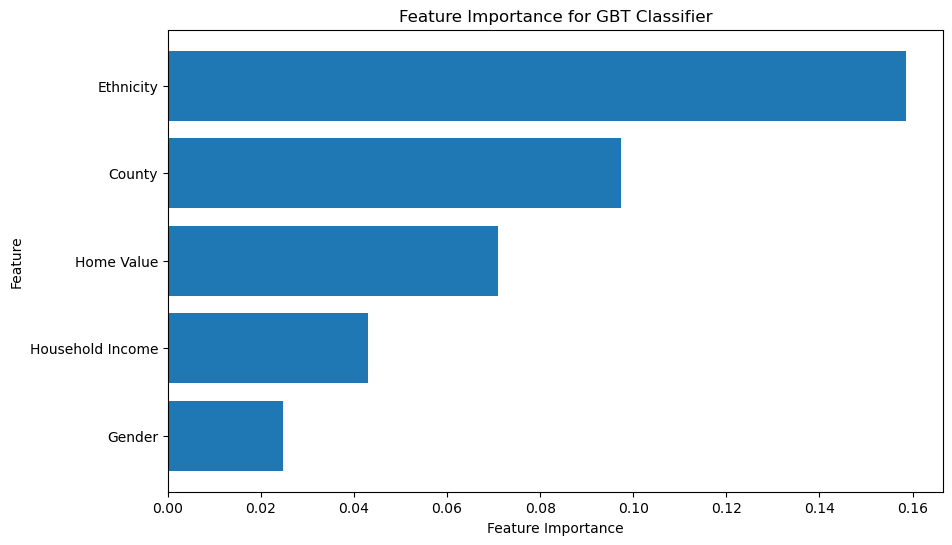

In [14]:
import matplotlib.pyplot as plt

# Extract feature importances from the trained GBT model
feature_importances = gbt_model.featureImportances

# Map feature importances to feature names
feature_names = feature_columns

# Create a dictionary mapping feature names to importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# Extract sorted feature names and importances
sorted_feature_names = [x[0] for x in sorted_features]
sorted_importances = [x[1] for x in sorted_features]

# Renaming the columns for display purposes
renamed_features = ['Gender', 'Household Income', 'Home Value', 'County', 'Ethnicity']

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(renamed_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for GBT Classifier')
plt.show()


It seems that ethnicity and county ended up being the most influential features in the model. Home value, houeshold income, and gender still seemed to be fairly influential, as their feature importance values aren't super close to 0. Gender ended up being the least influential for the model. Ethnicity being the most influential factor in determining party affiliation makes a lot of sense because different ethnic groups have different political leanings historical, social, and economic factors. Location, in the form of county, makes sense as the second highest influential factor based on the varying demographics and social dynamics of each county. There are 22 different counties in Wyoming, so this is very probable. Home value and household income could influence the model in some ways, as a voter's opinions on certain economic policies reflect their level of income.

# Conclusion

In conclusion, our project has provided valuable insights into the factors influencing voter participation rates and election party predictions for the state of Wyoming and generally. Through the utilization of various machine learning models including Logistic Regression, Support Vector Machines (SVM), Gradient Boosting, and Random Forest, we analyzed the impact of household income, county, home value, ethnic description, and gender.

Our exploratory data analysis (EDA) highlighted challenges such as the scarcity of inactive voters in the dataset, which posed difficulties in visualization and potentially skewed our findings. For example, the proportion of active voters to each ethnicity and each county is nearly 1, suggesting that almost everyone from each of these subgroups were an active voter. Additionally, limitations in the data collection process suggested biases that could have influenced our results.

In analyzing the models' performance, we observed remarkably similar accuracies across Logistic Regression (98.14%), Support Vector Machines (98.185%), Random Forest (98.185%), and Gradient Boosting Trees (98.1903%). This high level of accuracy suggests that the models were able to effectively classify voters as "active" or "inactive" in Wyoming. However, it is important to note that the accuracies may have been more of a result from the fact that most of the training data and test data included observations from only voters active. Thus is would be easier to classify this.

Additionally, despite the high accuracies, the ROC AUC values were relatively low across all models: Logistic Regression (0.5), SVM (0.61190), Random Forest (0.60401), and Gradient Boosting Trees (0.64316). This discrepancy between accuracy and ROC AUC suggests that while the models were able to correctly classify "active" and "inactive" voters with high accuracy, they struggled to effectively discriminate between the two classes when considering the trade-off between true positive rate and false positive rate.

Comparing the results our analysis yielded significant findings. For the first question concerning voter participation rates, while precise visualization was hindered by the limited data on inactive voters, our models provided insights into the influence of various factors.

Moving on to the second question regarding election party predictions, we observed a slightly lower model accuracy at 80%, yet a higher ROC, indicating improved performance in distinguishing between different party affiliations. Interestingly, the features of household income, county, home value, ethnic description, and gender emerged as stronger predictors for election party predictions, suggesting their heightened influence in determining political affiliations.

In conclusion, our project underscores the complexity of voter behavior and the multifaceted nature of predictive modeling in electoral contexts. While facing challenges such as data scarcity and potential biases, our analysis has shed light on the interplay between socio-demographic factors and political outcomes, offering valuable insights for future research and policy considerations.




